<a href="https://colab.research.google.com/github/cbsobral/ml-fies/blob/main/Module00_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Module 00 - Create Train and Test Sets

In this first module, we perform the following steps:

1. Load the data from Google Drive in two parts (the file is too big to load at once);
2. Exclude irrelevant variables or variables with too many missing values;
3. Rename variables in English and whenever possible with shorter names;
4. Perform correlation analysis on groups of variables. 

### 1 - Load Data



In [ ]:
import pandas as pd

url_a = "https://drive.google.com/file/d/1prPbFSiXFTHmTHzXTGxy4HrtRxXUHhce/view?usp=sharing"
path_a = "https://drive.google.com/uc?export=download&id="+url_a.split("/")[-2]
base_df_a = pd.read_excel(path_a)
base_df_a.shape

(309999, 37)

In [ ]:
url_b = "https://drive.google.com/file/d/1nGckSszPPifPvR3o5FeYaKArUYbfjHGn/view?usp=sharing"
path_b = "https://drive.google.com/uc?export=download&id="+url_b.split("/")[-2]
base_df_b = pd.read_excel(path_b)
base_df_b.shape

(327823, 37)

In [ ]:
complete_set = base_df_a.append(base_df_b)
complete_set.shape

(637822, 37)

### 2 - Adjust Variables

In this section, we rename the variables in the dataset and then create three new ones: 

*   `student`: binary variable to indicate whether the borrower has other occupation outside of being a student;
*   `default`: binary varible -- 1 if deliquency period of the loan is superior to 360 days and 0 otherwise;
* `age`: age calculate from the birth year. 

---





In [ ]:
# Student
complete_set = complete_set.assign(student = 1*(complete_set["DS_OCUPACAO"]=="Estudante"))

# Default
complete_set = complete_set.assign(default = 1*(complete_set["nu_dias_atraso"]>=360))

# Age
complete_set = complete_set[pd.to_numeric(complete_set["ANO_NASC"],errors='coerce').notna()]
complete_set = complete_set.assign(age = 2015 - (complete_set["ANO_NASC"]))

In [ ]:
new_names ={"NU_ANO_SEMESTRE_INSCRICAO":"semester_enroll",
            "SG_SEXO":"gender",
            "DS_OCUPACAO":"occupation",
            "DS_RACA_COR" : "ethnicity",
            "NU_ANO_CONCLUSAO_ENSINO_MEDIO":"high_school_endyear",
            "SG_UF_CURSO": "state_course",
            "QT_SEMESTRES_CURSO": "n_sem_course",
            "VL_SEMESTRE_COM_DESCONTO": "tuition_discounted",
            "NU_PERCENT_SOLICITADO_FINANC":"perc_requested",
            "VL_FINANC_RECURSO_ALUNO":"student_resource",
            "ANO_NASC":"birth_year",
            "DS_ESTADO_CIVIL":"marital_status", 
            "VL_RENDA_PESSOAL_BRUTA_MENSAL": "personal_income",
            "VL_RENDA_FAMILIAR_BRUTA_MENSAL": "family_income",
            "ST_ENSINO_MEDIO_ESCOLA_PUBLICA": "public_hs",
            "NO_CURSO": "degree",
            "QT_SEMESTRE_CONCLUIDO": "n_completed_sem",
            "VL_SEMESTRE_ATUAL": "tuition_current",
            "VL_FINANCIADO_SEMESTRE": "loan_value_sem",
            "fase_contrato": "contract_phase",
            "vl_divida": "total_debt",            
            "VL_AVALIACAO_IGC": "igc",
            "VL_FAIXA_CPC": "cpc",
            "VL_FAIXA_CC": "cc",
            "QT_SEMESTRE_FINANCIAMENTO": "sem_funded",
            "QT_MEMBRO": "fam_size",
            "VL_RENDA_PER_CAPITA":"income_pc",
            "NU_PERCENTUAL_COMPROMETIMENTO":"inc_prop",
            "VL_TOTAL_FINANCIAMENTO":"loan_value",
            "VL_LIMITE_GLOBAL":"loan_limit",
            "dt_inicio_cont":"date_contract"
}

complete_set = complete_set.rename(index=str, columns=new_names)
print(complete_set.columns)

Index(['semester_enroll', 'gender', 'occupation', 'marital_status',
       'family_income', 'personal_income', 'NO_MUNICIPIO', 'SG_UF',
       'ethnicity', 'public_hs', 'high_school_endyear',
       'NU_SEMESTRE_REFERENCIA', 'state_course', 'degree', 'igc', 'cpc', 'cc',
       'n_sem_course', 'n_completed_sem', 'sem_funded',
       'QT_MESES_FINANC_SEMESTRE_ATUAL', 'fam_size', 'income_pc',
       'VL_SEMESTRE_SEM_DESCONTO', 'tuition_discounted', 'tuition_current',
       'inc_prop', 'perc_requested', 'loan_value_sem', 'student_resource',
       'loan_value', 'loan_limit', 'date_contract', 'contract_phase',
       'nu_dias_atraso', 'total_debt', 'birth_year', 'student', 'default',
       'age'],
      dtype='object')


### 3 - Clean Dataset

In this section we drop unecessary variables, deal with wrong entries and outliers, drop NA's and adjust variable types.

Most of the variables were dropped due to inconsistencies and missing data. `nu_dias_atraso` was dropped as it was used to create the binary target variable `default`.

In [ ]:
variables_to_drop = ["NO_MUNICIPIO", # municipality
                     "SG_UF", # state
                     "VL_SEMESTRE_SEM_DESCONTO", # value of semester without discount
                     "NU_SEMESTRE_REFERENCIA", # semester of reference
                     "nu_dias_atraso", # period of deliquency
                     "QT_MESES_FINANC_SEMESTRE_ATUAL", # number of months for loans
                     "cpc", # university evaluation
                     "cc"] # university evaluation

complete_set_clean = complete_set.drop(variables_to_drop, axis = 1)                

The variable `loan_value_sem` (value of loan in the semester) has over 7,000 entries that are over 99 milion reais. We assume they are coding errors and recalculate them to be the equal to the value of the tuition (`tuition_current`) times the percentage of tuition requested as a loan (`perc_requested`). We also eliminate 4 outliers from `family_income`. Finally we filter `age` to include values ranging between 10 and 100 years old. 



In [ ]:
import numpy as np

complete_set_clean['loan_value_sem'] = np.where((complete_set_clean.loan_value_sem > 300000), 
                                          (complete_set_clean["perc_requested"]/100 * complete_set_clean["tuition_current"]), 
                                          complete_set_clean.loan_value_sem)

In [ ]:
complete_set_clean = complete_set_clean.loc[(complete_set_clean['family_income'] < 100000)] 

In [ ]:
complete_set_clean = complete_set_clean.loc[(complete_set_clean['age'] < 100) & (complete_set_clean['age'] > 10)] 

For the variables in the list below, we drop NAs, as they do not comprise a large share of observations. After this step, we end up with 620,919 instances. 

In [ ]:
complete_set_clean = complete_set_clean.dropna(subset=["semester_enroll",
                                                      "gender",
                                                       "occupation",
                                                       "marital_status",
                                                       "ethnicity",
                                                       "public_hs",
                                                       "state_course",
                                                       "degree",
                                                       "igc",
                                                       "contract_phase",
                                                       "high_school_endyear"])

The last step is adjusting some variable types. 

In [ ]:
import datetime as dt
              
complete_set_clean["date_contract"]= complete_set_clean["date_contract"].map(dt.datetime.toordinal)
complete_set_clean = complete_set_clean.astype({"semester_enroll":str, "igc":'int64'})

 ### 4 - Correlation Matrix

In this section, we perform a quick correlation analysis. The only variable to be dropped is `tuition_discounted`, since it has perfect correlation with another variable (`tuition_current`). The remainder will be subject to further analysis in the future. 

In [ ]:
corr_matrix = complete_set_clean.corr()
corr_matrix['default'].sort_values(ascending=False, key=pd.Series.abs)

default                1.000000
family_income         -0.226715
n_sem_course          -0.224457
income_pc             -0.207312
sem_funded            -0.190911
total_debt            -0.170652
loan_value            -0.166323
tuition_discounted    -0.148594
perc_requested         0.147961
tuition_current       -0.147188
student_resource      -0.144194
loan_limit            -0.138106
loan_value_sem        -0.109301
fam_size              -0.101595
igc                   -0.078512
student               -0.077310
date_contract         -0.064888
n_completed_sem        0.060517
inc_prop               0.046517
personal_income       -0.018339
high_school_endyear    0.014004
Name: default, dtype: float64

For the analysis, two subsets are created: 

* `corr_income`: containing variables related to family income;
* `corr_tuition`: containing variables related to tuition value.

In [ ]:
corr_income = complete_set_clean[['family_income', 'income_pc', 'fam_size', 'default']].copy()
corr_tuition = complete_set_clean[['tuition_discounted', 'tuition_current', 'loan_limit', 'loan_value_sem', 'loan_value', 'perc_requested', 'default']].copy()

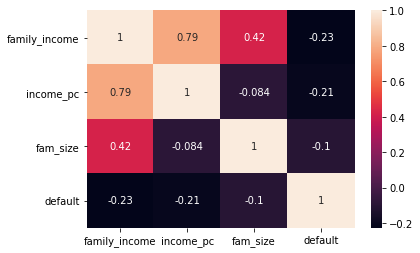

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = corr_income.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

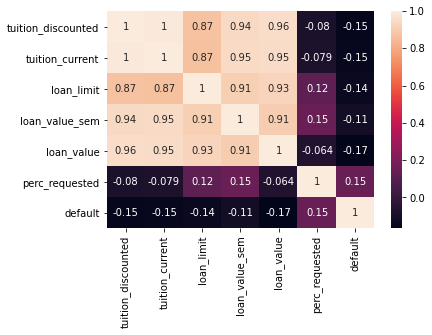

In [ ]:
corrMatrix = corr_tuition.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [ ]:
complete_set_clean = complete_set_clean.drop("tuition_discounted", axis=1)

### 5 - Creat Train and Test Sets

In this section we will create the training and test set using the function *train_test_split* from Scikit-Learn. Two important considerations about our choice:

* Our dataset is a sample provided by the Brazilian Governent and will not be updated. Therefore, we chose not to be concerned about future splits with updated data;

* Our original data includes 637,822 instances. After cleaning the dataset, we still have 620,919 instances. Thus, we assume it is big enough and do not employ stratified sampling.

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(complete_set_clean, test_size=0.2, random_state=42)

### 6 - Download Sets

In [ ]:
from google.colab import files

# Training dataset
train.to_csv('train.csv', index=False)
files.download('train.csv')

# Test dataset
test.to_csv('test.csv', index=False)
files.download('test.csv')